# COPDGene2 Fagerstrom Test For Nicotine Dependence (FTND) GWAS
__Author:__ Jesse Marks

See [GitHub Issue #78](emerge_ea.1000G.CAT_FTND~SNP+SEX+EVs.maf_gt_0.01_rsq_gt_0.30_ea.snps+indels.manhattan.png.gz)

This document logs the steps taken to process:

* `Genetic Epidemiology of COPD (COPDGene) Funded by the National Heart, Lung, and Blood Institute` data and perform the FTND GWAS. The [COPDGene](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/study.cgi?study_id=phs000179.v1.p1) cohort is racially diverse and sufficiently large and appropriately designed for genome-wide association analysis of COPD. 

* There are 10k subjects including control smokers, definitie COPD cases (GOLD Stage 2 to 4) and subjects not included in either group (GOLD 1 or GOLD-Unclassified). 

* The focus of this study is genome-wide association analysis to identify the genetic risk factors that determine susceptibility for COPD and COPD-related phenotypes.

* Our phenotype of interest is FTND

FTND is a standard instrument for assessing the physical addiction to nicotine. For more information, see [this website](https://cde.drugabuse.gov/instrument/d7c0b0f5-b865-e4de-e040-bb89ad43202b).

The imputed genotype are stored on Amazon Web Services S3 at:

`s3://rti-nd/COPDGene`

* **Note**: I will first perform the GWAS with only the autosomes 

* John Guo would like me to try this with the nextFlow pipeline

## Notes about study
**Note**: these notes are not cohesive but serve as a personal reference for information I gathered on the study

* we have 1000 Genomes phase 3 imputation already available on the full COPDGene dataset

* we will run COPDGene1 and COPDGene2 separately because FTND was collected several years apart and there were some key differences in the way that the questions were asked in the different waves. We will keep the two waves separate to circumvent any potential discrepancies which could arrise because of the phenotypes being less than harmonious and then we will combine them in a meta-analysis later. 


* I will run the GWAS analysis with the following variables:

**COPDGene2** (all data from phase 2 LFU dataset, except for gender and finalGOLD which was collected only in phase 1)
The criteria for COPDGene2 are:

```1) WstFTND_cat_p2 (mostly former smokers with some current smokers picked up)
2) age_p1 (age at current visit)
3) gender (1=male, 2=female)
4) Goldneg1 (between case and control - exhibits signs of both. Failed one diagnostic test while passing another.)
5) Gold1or2 (cases)
6) Gold3or4 (severe cases)
7) EVs to be selected```

**Also, I need to split the data up by race** (1=white, 2=black) 


**Note** We cannot assume that the increments in the GOLD classification are equal which is why we need to embed dummy variables rather than a single categorical variable in our regression models.

* GOLD stands for the Global Initiative for Chronic Obstructive Lung Disease. Essentially, GOLD it is a metric for quantifying the severity of COPD a patient has.

* FTND outcome and covariates are now ready at the path:
    
    `\\rcdcollaboration01.rti.ns\GxG\Analysis\COPDGene\phenotypes\Phase2\COPD Both waves with Cat FTND_v2.xls`
    

* For COPDGene1, we are increasing the sample size by several hundred. This is because, the previous analysis of COPDGene1 included only the subjects with determinant COPD GOLD status (finalGold=0 for controls, 1/2 for cases, and 3/4 for severe cases.) Now we know that subjects with an indeterminant status (i.e. finalGold=-1) were subjects that were classified to be between case and control. With this newfound knowledge, we can go ahead and include these subjects and rerun COPDGene1 with these subjects plus the subjects that were in the previous analysis. The model will be:

`CurFTND_cat_p1 = SNP + age_p1 + gender + Goldneg1 +Gold1or2 + Gold3or4 + EVs to be selected`
    * Also note that in this phase1, the subjects were all current smokers. (max N=5289)

* For phase2, COPDGene2, we need to exclude all of the subjects which were included in COPDGene1. This will leave *mostly* former smokers with lifetime FTND reported (max N=2934). There will be some current smokers picked up in phase2 and we will include them here.

`WstFTND_cat_p2 = SNP + age_p1 + gender + Goldneg1 +Gold1or2 + Gold3or4 + EVs to be selected`


* So, 2,934 is the maximum number of subjects that will be included in COPDGene2. We will have to filter this down based on if the subjects have `sex, age, GOLD status,` and `genotype data.` Also, there are reportedly 4 subjects for COPDGene2 (have entries for the WstFTND_cat_p2 variable) that are missing finalGold status. Of those 4, 3 marked 0 for `Goldneg1`, `Gold1or2`, or `Gold3or4` and the other 1 has NA for those three variables. We will treat these 4 subjects as missing and exclude them from the analysis.

### WstFTND_cat_p2 variable description
| cat | Freq |
|-----|------|
| 0   | 1,122 |   
| 1   | 1,286 |   
| 2   | 526   |   

* Where FTND conversion is 0=0-3, 1=4-6, and 2=7+

## Capturing missing subjects

There are two age variables of interest for this COPDGene2 study. One is `age_p1` and the other is `age_p2`. We would like to use the latest data, which is `age_p2` but there are 195 subjects that don't have this data. In the subjection titled "Impute missing age", we propose method which imputes from the `age_p1` data to estimate the missing `age_p2` data. In essence, we will create a new age variable `age_p3` which will allow us to incorporate those subjects that would have been lost if we had just went with the COPDGene2 subjects having `age_p2` data. 

**`age_p3` description **
* if a subject has `age_p2` data, then their `age_p3` is set equal to their `age_p2`
* if the subject is missing `age_p2` data, then impute from their `age_p1`
    * the data will be imputed by adding the average difference between `age_p2` and `age_p1` of the COPDGene2 subjects that have both `age_p1` and `age_p2` data. The average will be either the median or mean - this will be determined upon further discussion.
    
See section [missing subjects](#missing_subs) for details of this subject age imputation process.

# Prepare files for ProbABEL
## Phenotype Data COPDGene2
**Age p1 filtered table**

| Filtering Criterion                   | Subjects Removed  | Total |
|---------------------------------------|-------------------|-------|
| Initial Data                          | 0                 | 10,300|
| Initial subjects (WstFTND & !CurFTND) | 7,366             | 2,934 |
| Missing finalgold status              | 4                 | 2,930 |
| Missing sex                           | 0                 | 2,930 |
| Missing age (p1)                      | 0                 | 2,930 |
| Missing Genotype                      | 33                | 2,897 |

* Number of EAs: 2,630
* Number of AAs: 267

**Age p2 filtered table**

| Filtering Criterion                   | Subjects Removed  | Total |
|---------------------------------------|-------------------|-------|
| Initial Data                          | 0                 | 10,300|
| Initial subjects (WstFTND & !CurFTND) | 7,366             | 2,934 |
| Missing finalgold status              | 4                 | 2,930 |
| Missing sex                           | 0                 | 2,930 |
| Missing age (p2)                      | 195               | 2,735 |
| Missing Genotype                      | 32                | 2,703 |

* Number of EAs: 2,470
* Number of AAs: 233

### Apply Filters

In [1]:
pheno.data <- read.table("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/pheno/Copy of COPD Both waves with Cat FTND_v2.csv",
                        sep=",", header=T)
print("Below is the table head of the entire phenotype file.")
head(pheno.data)

[1] "Below is the table head of the entire phenotype file."


sid,gender,race,ethnic,fagerstrom_index,finalgold,age_p1,age_p2,have_lfu,fagerstrom_index_lfu,CurFTND_cat_p1,WstFTND_cat_p2,Gold_Cat,Goldneg1,Gold1or2,Gold3or4
15814W,2,1,2,NA,-2,NA,NA,,NA,NA,NA,NA,NA,NA,NA
16032X,1,1,2,NA,-2,NA,NA,,NA,NA,NA,NA,NA,NA,NA
16126G,2,1,2,NA,-2,NA,NA,,NA,NA,NA,NA,NA,NA,NA
16281S,2,1,2,NA,-2,NA,NA,,NA,NA,NA,NA,NA,NA,NA
16303C,1,1,2,NA,-2,NA,NA,,NA,NA,NA,NA,NA,NA,NA
16311B,2,1,2,NA,-2,NA,NA,,NA,NA,NA,NA,NA,NA,NA


#### Initial numbers

In [2]:
# COPDGene1
# Calculate number of subjects with CurFTND data
cur.ftnd.vec <-  which(pheno.data$CurFTND_cat_p1 >= 0)
#print("Max number of subjects for COPDGene1 (both ancestries)")
#length(cur.ftnd.vec)


#-----------------------------------------------------------------------------
# COPDGene2
# Calculate the number of subjects with WstFTND data but not CurFTND data

# The indices in cur.ftnd.vec at which the subjects have both wstFTND and CurFTND data
overlap1 <- which(pheno.data$WstFTND_cat_p2[cur.ftnd.vec] >= 0)

# This gives the subject indices which have both wst and cur data
wst.cur.overlap.vec <- cur.ftnd.vec[overlap1]

# Indices of all the subjects with WstFTND data
all.wst <- which(pheno.data$WstFTND_cat_p2 >= 0)

# Subjects that have WstFTND data and no CurFTND data
wst.ftnd.vec <- setdiff(all.wst, wst.cur.overlap.vec) 

print("Max number of subjects for COPDGene2 (both ancestries)")
# calculate subjects that are exclusively WstFTND (subtract those that have both Cur and Wst)
length(wst.ftnd.vec)

# Categorical FTND summary
print("Categorical FTND summary")
table(pheno.data$WstFTND_cat_p2[wst.ftnd.vec])

wst.ftnd.data <- pheno.data[wst.ftnd.vec,]
print("Below is the table head of the COPDGene2 data before any filters (save FTND) have been applied.")
head(wst.ftnd.data)

[1] "Max number of subjects for COPDGene2 (both ancestries)"


[1] 2934

[1] "Categorical FTND summary"



   0    1    2 
1122 1286  526 

[1] "Below is the table head of the COPDGene2 data before any filters (save FTND) have been applied."


,sid,gender,race,ethnic,fagerstrom_index,finalgold,age_p1,age_p2,have_lfu,fagerstrom_index_lfu,CurFTND_cat_p1,WstFTND_cat_p2,Gold_Cat,Goldneg1,Gold1or2,Gold3or4
103,10161E,1,1,2,NA,-1,73.8,79.1,LFU,9,NA,2,1,1,0,0
105,10260G,1,1,2,NA,-1,68.4,73.9,LFU,5,NA,1,1,1,0,0
107,10489M,2,1,2,NA,-1,60.0,65.8,LFU,4,NA,1,1,1,0,0
108,10511F,2,1,2,NA,-1,80.6,87.4,LFU,3,NA,0,1,1,0,0
110,10558F,1,1,2,NA,-1,60.9,66.8,LFU,5,NA,1,1,1,0,0
118,10771F,1,1,2,NA,-1,69.9,75.6,LFU,3,NA,0,1,1,0,0


#### Missing finalgold filter
Remove subjects missing `finalgold` variable

In [3]:
# some subjects with reported GOLD status are missing in the finalgold variable
gold.data <- wst.ftnd.data$finalgold[]
print("These are the sequential indices in the wst.ftnd.data at which they occur.")
which(is.na(gold.data))
print("Number of subjects missing finalgold.")
length(which(is.na(gold.data)))

print("Here are the data of those subjects with missing finalgold.")
wst.ftnd.data[which(is.na(gold.data)),]

# exclude those subjects with missing finalgold
wst.ftnd.fg.filtered <- wst.ftnd.data[-which(is.na(gold.data)),]

print("Number of subjects remaining after filtering by missing finalgold data.")
length(wst.ftnd.fg.filtered[,1])

[1] "These are the sequential indices in the wst.ftnd.data at which they occur."


[1] 2659 2660 2661 2934

[1] "Number of subjects missing finalgold."


[1] 4

[1] "Here are the data of those subjects with missing finalgold."


,sid,gender,race,ethnic,fagerstrom_index,finalgold,age_p1,age_p2,have_lfu,fagerstrom_index_lfu,CurFTND_cat_p1,WstFTND_cat_p2,Gold_Cat,Goldneg1,Gold1or2,Gold3or4
6865,10126C,2,1,2,NA,NA,72.0,77.7,LFU,2,NA,0,NA,0,0,0
6873,15118C,1,1,2,NA,NA,70.7,76.2,LFU,7,NA,2,NA,0,0,0
6884,25119K,1,1,2,NA,NA,74.9,80.2,LFU,1,NA,0,NA,0,0,0
10297,25532S,1,2,2,NA,NA,63.5,68.8,LFU,5,NA,1,NA,NA,NA,NA


[1] "Number of subjects remaining after filtering by missing finalgold data."


[1] 2930

#### Missing Sex filter
Remove any subjects missing sex data.

In [4]:
# filtered out any subjects missing sex data
wst.ftnd.fg.sex.filtered <- wst.ftnd.fg.filtered[complete.cases(wst.ftnd.fg.filtered[, "gender"]),]

print("Number of COPDGene2 subjects after FTND, finalgold, and sex filtering.")
length(wst.ftnd.fg.sex.filtered[,1])

[1] "Number of COPDGene2 subjects after FTND, finalgold, and sex filtering."


[1] 2930

**Note:** no subjects missing sex data. 

#### Missing Age filter
Remove any subjects missing age data. 

**Note**: the filter we ultimately end up using is the imputed variable `age_p3`.

##### age_p1
Filter by variable `age_p1` then write to file.

In [5]:
wst.ftnd.fg.sex.age1.filter <- wst.ftnd.fg.sex.filtered[complete.cases(wst.ftnd.fg.sex.filtered[,"age_p1"]),]

print("Number of COPDGene2 subjects after FTND, finalgold, sex, and age (p1) filtering.")
length(wst.ftnd.fg.sex.age1.filter[,1])

variables.of.interest1 <- c("sid", "gender", "race", "age_p1", "WstFTND_cat_p2", "Goldneg1", "Gold1or2", "Gold3or4")
pheno1 <- wst.ftnd.fg.sex.age1.filter[,variables.of.interest1]

print("Head of filtered data (age_p1).")
head(pheno1)

setwd("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/pheno/two")
write.table(pheno1, "phenotype.ftnd.fg.sex.age1.filtered.txt", sep = " ", row.names = F, quote = F)

[1] "Number of COPDGene2 subjects after FTND, finalgold, sex, and age (p1) filtering."


[1] 2930

[1] "Head of filtered data (age_p1)."


,sid,gender,race,age_p1,WstFTND_cat_p2,Goldneg1,Gold1or2,Gold3or4
103,10161E,1,1,73.8,2,1,0,0
105,10260G,1,1,68.4,1,1,0,0
107,10489M,2,1,60.0,1,1,0,0
108,10511F,2,1,80.6,0,1,0,0
110,10558F,1,1,60.9,1,1,0,0
118,10771F,1,1,69.9,0,1,0,0


##### age_p2

Filter by variable `age_p2` then write to file.

In [6]:
wst.ftnd.fg.sex.age2.filter <- wst.ftnd.fg.sex.filtered[complete.cases(wst.ftnd.fg.sex.filtered[,"age_p2"]),]

print("Number of COPDGene2 subjects after FTND, finalgold, sex, and age (p2) filtering.")
length(wst.ftnd.fg.sex.age2.filter[,1])

variables.of.interest2 <- c("sid", "gender", "race", "age_p2", "WstFTND_cat_p2", "Goldneg1", "Gold1or2", "Gold3or4")
pheno2 <- wst.ftnd.fg.sex.age2.filter[,variables.of.interest2]

print("Head of filtered data (age_p2).")
head(pheno2)

setwd("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/pheno/two")
write.table(pheno2, "phenotype.ftnd.fg.sex.age2.filtered.txt", sep = " ", row.names = F, quote = F)

[1] "Number of COPDGene2 subjects after FTND, finalgold, sex, and age (p2) filtering."


[1] 2735

[1] "Head of filtered data (age_p2)."


,sid,gender,race,age_p2,WstFTND_cat_p2,Goldneg1,Gold1or2,Gold3or4
103,10161E,1,1,79.1,2,1,0,0
105,10260G,1,1,73.9,1,1,0,0
107,10489M,2,1,65.8,1,1,0,0
108,10511F,2,1,87.4,0,1,0,0
110,10558F,1,1,66.8,1,1,0,0
118,10771F,1,1,75.6,0,1,0,0


##### Impute missing age `age_p3`
Going to impute the missing age data for the subjects that have missing `age_p2` data. We will do this by creating a third variable `age_p3` which finds the median (or mean) of the age difference between the subjects that have data at both `age_p1` and `age_p2`. I will add the median (or mean) of this age difference to `age_p1` to produce the new entry for `age_p3` for the subjects that have missing `age_p2` data. If the subject is not missing `age_p2`, then the value of `age_p3` for that subject will just be the value given at `age_p2`.

<a id='missing_subs'></a>

[1] "Head of table for data pre-age filtered."


,sid,gender,race,ethnic,fagerstrom_index,finalgold,age_p1,age_p2,have_lfu,fagerstrom_index_lfu,CurFTND_cat_p1,WstFTND_cat_p2,Gold_Cat,Goldneg1,Gold1or2,Gold3or4
103,10161E,1,1,2,NA,-1,73.8,79.1,LFU,9,NA,2,1,1,0,0
105,10260G,1,1,2,NA,-1,68.4,73.9,LFU,5,NA,1,1,1,0,0
107,10489M,2,1,2,NA,-1,60.0,65.8,LFU,4,NA,1,1,1,0,0
108,10511F,2,1,2,NA,-1,80.6,87.4,LFU,3,NA,0,1,1,0,0
110,10558F,1,1,2,NA,-1,60.9,66.8,LFU,5,NA,1,1,1,0,0
118,10771F,1,1,2,NA,-1,69.9,75.6,LFU,3,NA,0,1,1,0,0


The mean age difference of age_p2 and age_p1 of COPDGene2 subjects is:  5.604552
The median age difference of age_p2 and age_p1 of COPDGene2 subjects is:  5.400002

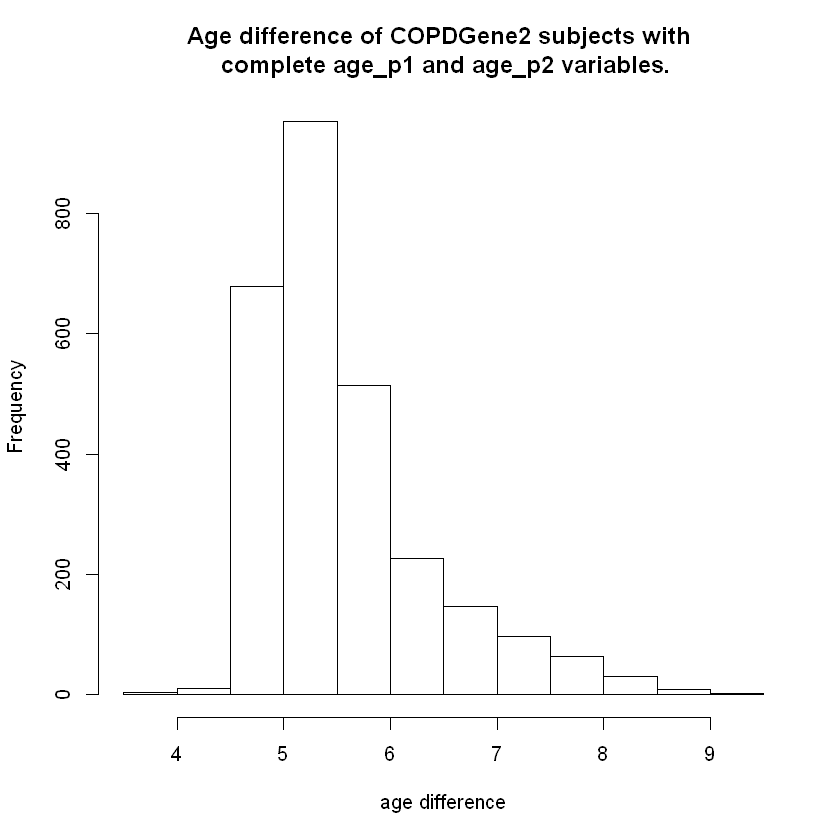

In [7]:
# COPDGene2 subjects pre-age filtering
print("Head of table for data pre-age filtered.")
#head(wst.ftnd.fg.sex.filtered)

age_intersect_df <- wst.ftnd.fg.sex.filtered[complete.cases(wst.ftnd.fg.sex.filtered$age_p1, wst.ftnd.fg.sex.filtered$age_p2),]
age_p3 <- wst.ftnd.fg.sex.filtered$age_p2 - wst.ftnd.fg.sex.filtered$age_p1
head(age_intersect_df)

mean_age_dif <- mean(age_intersect_df$age_p2 - age_intersect_df$age_p1)
cat("The mean age difference of age_p2 and age_p1 of COPDGene2 subjects is: " , mean_age_dif)

median_age_dif <- median(age_intersect_df$age_p2 - age_intersect_df$age_p1)
cat("\n")
cat("The median age difference of age_p2 and age_p1 of COPDGene2 subjects is: " , median_age_dif)

# get a distribution of the age 
hist(age_p3, main = "Age difference of COPDGene2 subjects with \n complete age_p1 and age_p2 variables.",
    xlab = "age difference")
# add the third variable age_p3 in the dataframe.

In [49]:
library(tibble)

wst.ftnd.fg.sex.age3.filtered <- add_column(wst.ftnd.fg.sex.filtered, age_p3 =wst.ftnd.fg.sex.filtered$age_p2 , .after = 8)

# replace NA values in age_p3 with the value from age_p1 + median_age_dif (between age_p2 and age_p1)
for(i in 1:nrow(wst.ftnd.fg.sex.age3.filtered)){
    if (is.na(wst.ftnd.fg.sex.age3.filtered[i, "age_p3"])){
        wst.ftnd.fg.sex.age3.filtered[i, "age_p3"] <- wst.ftnd.fg.sex.age3.filtered[i, "age_p1"] + median_age_dif
    }
}
#length(wst.ftnd.fg.sex.age3.filtered[,1])

variables.of.interest3 <- c("sid", "gender", "race", "age_p3", "WstFTND_cat_p2", "Goldneg1", "Gold1or2", "Gold3or4")
wst.ftnd.fg.sex.age3.filtered <- wst.ftnd.fg.sex.age3.filtered[, variables.of.interest3]

head(wst.ftnd.fg.sex.age3.filtered)
# next I need to subset this dataframe to only the columns of interest and then save it to file

setwd("C:/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/pheno/two")
write.table(pheno1, "phenotype.ftnd.fg.sex.age3.filtered.txt", sep = " ", row.names = F, quote = F)

,sid,gender,race,age_p3,WstFTND_cat_p2,Goldneg1,Gold1or2,Gold3or4
103,10161E,1,1,79.1,2,1,0,0
105,10260G,1,1,73.9,1,1,0,0
107,10489M,2,1,65.8,1,1,0,0
108,10511F,2,1,87.4,0,1,0,0
110,10558F,1,1,66.8,1,1,0,0
118,10771F,1,1,75.6,0,1,0,0


#### Genotype filter V1

Construct subject-filtered PLINK file sets by filterine out subjects missing genotype data.

* This version is when we were testing the two datasets, one that include `age_p1` and the other that included `age_p2`
* See the section below [genotype filter V2](#geno2) for the filtering that was ultimately used which was on the phenotype data that included the newly created variable `age_p3`

In [ ]:
## local machine ##
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Nicotine/COPDGene/pheno/two

# create directory structure on MIDAS
mkdir -p /share/nas03/jmarks/studies/copdgene2/{eigenstrat,data/{assoc_tests,genotype/{observed,imputed},phenotype}}

# copy phenotype data over to MIDAS
#scp phenotype.ftnd.fg.sex.age1.filtered.txt jmarks@rtplhpc01.rti.ns:/share/nas03/jmarks/studies/copdgene2/data/phenotype/
#scp phenotype.ftnd.fg.sex.age2.filtered.txt jmarks@rtplhpc01.rti.ns:/share/nas03/jmarks/studies/copdgene2/data/phenotype/
scp phenotype.ftnd.fg.sex.age3.filtered.txt jmarks@rtplhpc01.rti.ns:/share/nas03/jmarks/studies/copdgene2/data/phenotype/

In [ ]:
## MIDAS console ##
cd /share/nas03/jmarks/studies/copdgene2/data/

cp /share/nas03/bioinformatics_group/data/studies/copdgene/observed/final_filtered/gxg_qc/copdgene.{aa,ea}.{fam,bim,bed} \
    genotype/observed

## create a new PLINK fam file based on subjects with phenotype and genotype data
### age_p1 filter
#### EA
#awk 'FNR==NR {a[$1]; next} ($2 in a)' phenotype/phenotype.ftnd.fg.sex.age1.filtered.txt \
#    genotype/observed/copdgene.ea.fam > phenotype/ea.phenotype1.all.filters.txt
#     
#### AA
#awk 'FNR==NR {a[$1]; next} ($2 in a)' phenotype/phenotype.ftnd.fg.sex.age1.filtered.txt \
#    genotype/observed/copdgene.aa.fam > phenotype/aa.phenotype1.all.filters.txt
#     
#
### age_p2 filter
#### EA
#awk 'FNR==NR {a[$1]; next} ($2 in a)' phenotype/phenotype.ftnd.fg.sex.age2.filtered.txt\
#    genotype/observed/copdgene.ea.fam > phenotype/ea.phenotype2.all.filters.txt
#     
#### AA
#awk 'FNR==NR {a[$1]; next} ($2 in a)' phenotype/phenotype.ftnd.fg.sex.age2.filtered.txt \
#    genotype/observed/copdgene.aa.fam > phenotype/aa.phenotype2.all.filters.txt
#     

#### Genotype filter V02
Construct subject-filtered PLINK file sets by filtering out subjects missing genotype data.

<a id='geno2'></a>

In [ ]:
## MIDAS console ##
cd /share/nas03/jmarks/studies/copdgene2/data/

# create a new PLINK fam file based on subjects with phenotype and genotype data
## age_p1 filter
### EA
awk 'FNR==NR {a[$1]; next} ($2 in a)' phenotype/phenotype.ftnd.fg.sex.age3.filtered.txt \
    genotype/observed/copdgene.ea.fam > phenotype/ea.phenotype3.all.filters.fam
     
### AA
awk 'FNR==NR {a[$1]; next} ($2 in a)' phenotype/phenotype.ftnd.fg.sex.age3.filtered.txt \
    genotype/observed/copdgene.aa.fam > phenotype/aa.phenotype3.all.filters.fam



### PCA (EIGENSTRAT)

To obtain principal component covariates to use in the GWAS statistical model, EIGENSTRAT is run on LD-pruned observed genotypes for each ancestry group. 

#### Construct subject-filtered PLINK file sets

In [ ]:
## MIDAS ##
cd /share/nas03/jmarks/studies/copdgene/two/

# EA
awk ' NR>=2 { print $1 }' ea.phenotype.age1.txt > ea.id_list1.txt
awk ' NR>=2 { print $1 }' ea.phenotype.age2.txt > ea.id_list2.txt

awk 'FNR==NR{a[$0];next} ($2 in a)' ea.id_list1.txt ../../observed/processing/copdgene.ea.fam > ea.filtered1.fam
awk 'FNR==NR{a[$0];next} ($2 in a)' ea.id_list2.txt ../../observed/processing/copdgene.ea.fam > ea.filtered2.fam

# AA
awk ' NR>=2 { print $1 }' aa.phenotype.age1.txt > aa.id_list1.txt
awk ' NR>=2 { print $1 }' aa.phenotype.age2.txt > aa.id_list2.txt

awk 'FNR==NR{a[$0];next} ($2 in a)' aa.id_list1.txt ../../observed/processing/copdgene.aa.fam > aa.filtered1.fam
awk 'FNR==NR{a[$0];next} ($2 in a)' aa.id_list2.txt ../../observed/processing/copdgene.aa.fam > aa.filtered2.fam

#awk 'FNR==NR{a[$0];next} ($2 in a)' id_list.txt ../../genotype/original/ea_chr_all.fam > filtered.fam

awk '{print $1,$2 }' filtered.fam > ea_subject_ids.keep

# Remove subjects by phenotype criteria
ancestry="ea"
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile ../../genotype/original/ea_chr_all \
    --keep ea_subject_ids.keep \
    --make-bed \
    --out /shared/s3/emerge/eigenstrat_no_sex/${ancestry}_pheno_filter